# Pyroadacoustics Demo

This notebook is intended to showcase *pyroadacoustics* and serve as a tutorial for the setup of the simulation scene. With this goal, we provide a description of the main commands and simulation options that can be selected.

For a detailed description of all the classes, methods, and parameters, please refer to the documentation of the individual classes.

### Description of the Simulator 

Pyroadacoustics aims to simulate the sound propagation on a non-urban road, such as a highway. In this context, the sound propagation is modeled as the sum of two component:
- The direct sound field, propagating from the position of the source to the position of the receiver
- The sound reflected from the ground surface

The simulator implements the following effects:
- Doppler effect, depending on the relative speed between the sound source and the receiver
- Air absorption, depending on the distance between the source and the receiver
- Asphalt reflection, depending on the absorption properties of the asphalt surface and on the angle of incidence of the sound wave

### Simulator Structure
The code of *pyrodacoustics* is structured in 4 classes:
- `DelayLine`: implements the delay line element, main building block of the simulator, used to simulate sound propagation and Doppler effect.
- `SoundSource`: contain the properties of the sound source used in the simulation scene, namely its position, trajectory, speed and sound signal.
- `MicrophoneArray`: defines the array of microphones used to capture the simulated sound. The microphone array is characterized by the number of microphones and their position in the simulation scene. The microphones are assumed to be static.
- `Material`: contains the acoustic properties of the asphalt road, i.e. its absorption and reflection coefficients.
- `Environment`: defines the simulation scenario and contains the code to start the simulation.
- `SimulatorManager`: contains the simulation logic.

The access point to the package, used to define the simulation scenario and start the simulation is the `Environment` class. This class allows the user to define:
1. The atmospheric conditions used for the simulations. These are specified by:
    - Temperature T, in degree Celsius
    - pressure P, in atmospheres
    - relative humidity, as a percentage
2. The microphone array used in the simulation. Each microphone is specified as a set of Cartesian coordinates denoting its position
3. The sound source that emits the sound signal. Its behavior is characterized by:
    - the emitted sound signal
    - the initial position (if the source is static, this corresponds to its position during the whole simulation)
    - the trajectory, defined as a set of points and a speed value `v` for each couple of point. The source is assumed to move along a straight line between each successive couple of points, at speed `v`.
4. The material of the road surface, that can be chosen from the database `materials.json` or defined as a new `Material` object by the user (see `Material` documentation for details)
5. A diffuse static background noise to be added to the simulation, defined by:
    - the noise signal 
    - the SNR level
6. The sampling frequency used for the simulation

## Simulation Tutorial

In [15]:
# Import pyroadacoustics package
import pyroadacoustics as pyroad

# Import auxiliary packages
import numpy as np
import scipy.signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

#### Definition of the Environment

To start building the simulation, we create an `Environment` object, that contains the scene that will be simulated. We do this by calling the `Environment` constructor, and specifying:
- Temperature (in Celsius) &rarr; default = 20
- Pressure (in atm) &rarr; default = 1
- Relative Humidity (percentage) &rarr; default = 50
- Sampling Frequency (in Hz) &rarr; default = 8000
- Road Material &rarr; default = *Average Asphalt*

If no argument is specified, the parameters will take the indicated default values.

In [16]:
# Sampling Frequency
fs = 8000

# Atmospheric Parameters
T = 20
p = 1
h_rel = 50

env = pyroad.Environment(fs = fs, temperature = T, pressure = p, rel_humidity = h_rel)


We then add a sound source, by calling the `add_source` method, that takes as arguments:
- The position of the source &rarr; required
- The source signal &rarr; if `None`, a default modulated sinusoidal signal is assigned
- The trajectory points &rarr; if `None` the source is assumed to be static at its position
- Source velocity &rarr; can be a single value (constant speed) or a value for each couple of successive trajectory points, indicating the speed in the segment specified by those points.


In [17]:
# Define source signal
t = np.arange(0,5,1/fs)

# 1. Sinusoidal Signal
f = 2000
src_signal = np.sin(2 * np.pi * f * t)

# 2. White noise signal
# src_signal = np.random.randn(len(t))

# 3. Audio Signal from WAV file
# samplerate, data = wavfile.read('file_name_signal.wav')
# data = scipy.signal.resample(data, int(len(data) * fs / samplerate))    # Resample to fs
# # Take only first channel and normalize to max value
# data = np.reshape(data[:,0], (-1, 1))
# data = data / max(data)
# data = np.reshape(data, -1)


env.add_source(position = np.array([3,20,1]), signal=src_signal, trajectory_points=np.array([[3,20,1], [3,-20,1]]), source_velocity=np.array([5]))


We now add the microphone array, defined by indicating a set of Cartesian coordinates [x,y,z] for each microphone in the array. We also set the noise signal, specified by:
- the signal samples &rarr; default is white noise signal
- the SNR &rarr; default = 15dB

In [18]:
# Add microphone array
mic_array = np.array([[0,0,1], [0,0.5,1]])
env.add_microphone_array(mic_array)

# Add noise signal

# 1. Default white noise
env.set_background_noise(SNR = 0)

# 2. User defined noise
# noise = np.random.randn(3*fs)
# b, a = scipy.signal.butter(3, 2000, 'lp', fs = fs)
# filtered_noise = scipy.signal.filtfilt(b, a, noise)
# env.set_background_noise(filtered_noise, SNR = 0)

# 3. Noise from WAV file
# samplerate, noise = wavfile.read('file_name_noise.wav')
# noise = scipy.signal.resample(noise, int(len(noise) * fs / samplerate))   # Resample to fs
# # Take only first channel and normalize to max value
# noise = np.reshape(noise[:,0], (-1, 1))
# noise = noise / max(noise)
# noise = np.reshape(noise, -1)
# env.set_background_noise(noise, SNR = 0)


Finally, we can set three simulation parameters that define how the signal is filtered during the simulation.

1. The first parameter is the interpolation method used for fractional delay line reads. There are three available interpolators:
    - `Linear`
    - `Allpass`
    - `Windowed-Sinc`
2. The second parameter defines whether to simulate just the direct sound field or also the ground reflection. It is set as a boolean: when `True`, the ground reflection is included.
3. The third parameter defines whether to include the air absorption filtering in the simulation. It is set as a boolean: when `True`, the air absorption is included

In [19]:
interp_method = "Allpass"
include_reflection = True
include_air_absorption = True

env.set_simulation_params(interp_method, include_reflection, include_air_absorption)

We can now run the simulation, compute the output signals and make some plots for analysis

/Users/stefano/Documents/KU Leuven/python-projects/pyroadacoustics/pyroadacoustics/simulatorManager.py:369: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_eval = filt_coeffs.dot(list(self._read4Buf))


Text(0, 0.5, 'Frequency [Hz]')

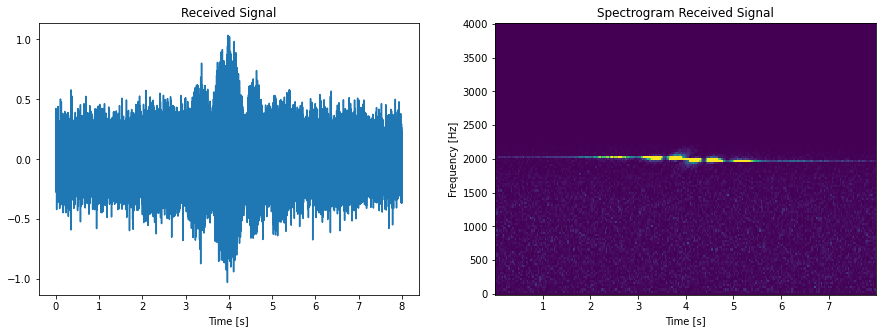

In [23]:
# Run simulation 
signal = env.simulate()

# Compute spectrogram of received signal
ff, tt, Sxx = scipy.signal.spectrogram(signal[0], fs = fs)

# Plots
fig, axs = plt.subplots(1,2, figsize = (15,5))

# Waveform Received Signal
axs[0].plot(np.arange(len(signal[0]))/fs, signal[0])
axs[0].set_title('Received Signal')
axs[0].set_xlabel('Time [s]')

# Spectrogram Received Signal
axs[1].pcolormesh(tt, ff, Sxx, shading='auto', vmax = 0.0004, rasterized=True)
axs[1].set_title('Spectrogram Received Signal')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Frequency [Hz]')



In [21]:
# Save Audio File

# Limit loudness
signal[0] = signal[0] / max(abs(signal[0]))

wavfile.write('demo_audio.wav', fs, signal[0])